## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [3]:
#from get_data import unpack
#unpack('facial-keypoints-data.zip')
import os
print(os.listdir()[3])

example.png


Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [69]:
### Useful routines for preparing data
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
from tqdm import tqdm
from zipfile import ZipFile
import cv2
final_size = 100 # final size of the image
def load_imgs_and_keypoints(dirname='facial-keypoints'):
    gt = pd.read_csv('gt.csv')
    N = gt.shape[0]
    imgs = zeros(shape=(N, 100, 100, 3))
    points = zeros(shape=(N, 28))
    zf = ZipFile("images.zip", 'r')
    #print(zf.infolist())
    for i in tqdm(range(N)):
        
        image = imread(zf.open('images/' + gt.loc[i, 'filename']))
        imgs[i] = resize(image, (final_size, final_size, 3))
        old_sizes = imread(zf.open('images/' + gt.loc[i, 'filename'])).shape

        points[i] = array(gt.iloc[i, 1:])
        for j in range(28):
            if j % 2 == 0:
                points[i][j] /= old_sizes[0]
            else:
                points[i][j] /= old_sizes[1]
            points[i][j] -= 0.5
    return imgs, points

imgs, points = load_imgs_and_keypoints()


  0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 6000/6000 [03:25<00:00, 29.21it/s] 


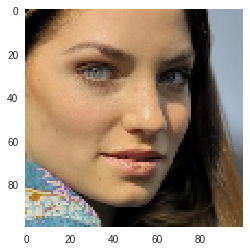

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

In [70]:
# Example of output
%matplotlib inline
from matplotlib import pyplot as plt
from skimage.io import imshow
plt.imshow(imgs[0],zorder=1)
plt.show()
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

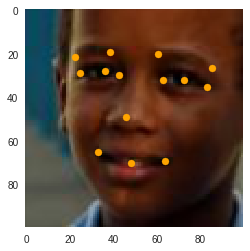

In [71]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    plt.imshow(img,zorder=1)
    x=[]
    y=[]
    for j in range(28):
        if j % 2 == 0:
            x.append((points[j]+0.5)*final_size)
        else:
            y.append((points[j]+0.5)*final_size)

    plt.scatter(x,y,zorder=2,color="orange")
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

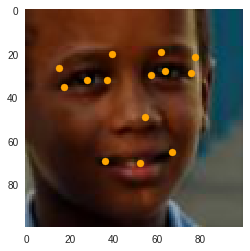

In [131]:
swap_pairs = {3:0, 2:1, 9:4, 8:5, 7:6, 13:11}
def flip_img(img, points):
    # Write your code for flipping here
    flip_img = cv2.flip(img,1)
    f_points = []
    for i in range(len(points)//2):
        f_points.append(-points[2*i])
        f_points.append(points[2*i+1])
    # Make sure the points are still in the right order
    for j in swap_pairs.keys():
        f_points[2*j],f_points[2*swap_pairs[j]] = f_points[2*swap_pairs[j]],f_points[2*j]
        f_points[2*j+1],f_points[2*swap_pairs[j]+1] = f_points[2*swap_pairs[j]+1],f_points[2*j+1]
    return flip_img,f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [132]:
# Write your code here
N = imgs_train.shape[0] 
aug_imgs_train = zeros(shape=(2*N, 100, 100, 3))
aug_points_train = zeros(shape=(2*N, 28))
for i in tqdm(range(0,N)):
    aug_imgs_train[2*i] = imgs_train[i]
    aug_points_train[2*i] = points_train[i]
    aug_imgs_train[2*i+1], aug_points_train[2*i+1] = flip_img(imgs_train[i], points_train[i])

100%|██████████| 5400/5400 [00:01<00:00, 2724.04it/s]


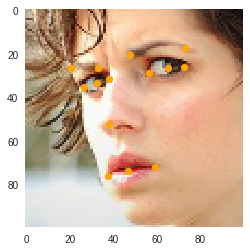

In [138]:
visualize_points(aug_imgs_train[12], aug_points_train[12])

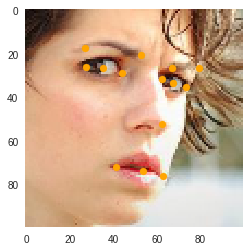

In [139]:
visualize_points(aug_imgs_train[13], aug_points_train[13])

In [140]:
print(aug_imgs_train.shape)
print(aug_points_train.shape)

(10800, 100, 100, 3)
(10800, 28)


In [141]:
import gc
collect = gc.collect()
print(collect)

9047


### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', input_shape=(100,100,3),activation ='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid',activation ='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid',activation ='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid',activation ='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation ='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation ='softsign'))

In [142]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)
num_classes = 28
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape = (100,100,3), kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
# Dropout before last layer doesn't help much
# Last layer activation should be linear so that preditions are in [-0.5,0.5], there is no need to "squash"
model.add(Dense(28, activation='linear', kernel_initializer='glorot_uniform'))
model.summary()
# Define here your model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 12800)             0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [143]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import keras_utils
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler        
BATCH_SIZE = 8
EPOCHS = 25

from keras.models import load_model
model.compile(loss='mse', optimizer = Adam(), metrics=['mae'])
checkpointer = ModelCheckpoint(filepath='best.h5', verbose=1, 
                               save_best_only=True)
callbacks = [checkpointer]
history = model.fit(
    aug_imgs_train, aug_points_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(imgs_val, points_val)
)
score = model.evaluate(imgs_val, points_val, batch_size=8)

Train on 10800 samples, validate on 600 samples
Epoch 1/25
10800/10800 [==============================] - 38s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0018 - val_mean_absolute_error: 0.0253

Epoch 00001: val_loss improved from inf to 0.00181, saving model to best.h5
Epoch 2/25
10800/10800 [==============================] - 45s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0258 - val_loss: 0.0016 - val_mean_absolute_error: 0.0247

Epoch 00002: val_loss improved from 0.00181 to 0.00161, saving model to best.h5
Epoch 3/25
10800/10800 [==============================] - 49s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0249 - val_loss: 0.0014 - val_mean_absolute_error: 0.0233

Epoch 00003: val_loss improved from 0.00161 to 0.00141, saving model to best.h5
Epoch 4/25
10800/10800 [==============================] - 47s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0243 - val_loss: 0.0014 - val_mean_absolute_error: 0.0232

Epoch 00004: val_loss did not improv

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [0]:
model = load_model("best.h5")


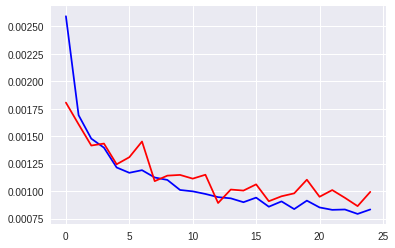

In [145]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss",)
plt.show()

In [146]:
predict = model.predict(aug_imgs_val)
predict[0]
# Example of output

array([-0.21049717, -0.35591513,  0.00105892, -0.34228504,  0.2081968 ,
       -0.26483136,  0.38835835, -0.15187654, -0.19293737, -0.26296717,
       -0.11992782, -0.25089675, -0.05115394, -0.2249853 ,  0.18451695,
       -0.14769927,  0.24928764, -0.12136006,  0.32013914, -0.08305417,
        0.02480849, -0.07263146, -0.20857637,  0.10974495, -0.05254937,
        0.14800286,  0.09412366,  0.20108858], dtype=float32)

True


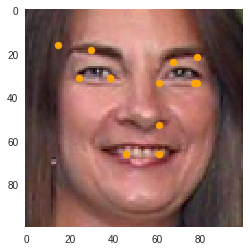

In [159]:
print("True")
visualize_points(imgs_val[23], points_val[23])

Predicted


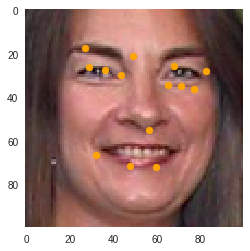

In [160]:
print("Predicted")
visualize_points(imgs_val[23], predict[23])

True


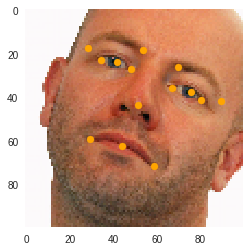

Predicted


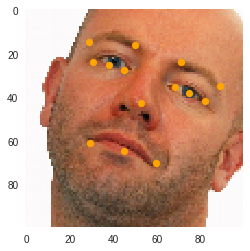

True


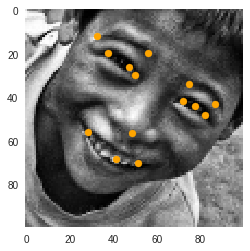

Predicted


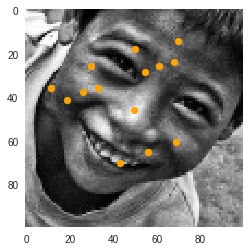

True


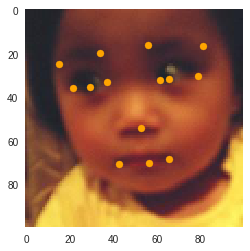

Predicted


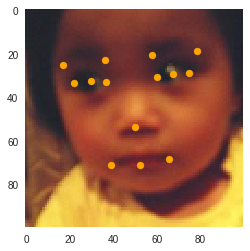

True


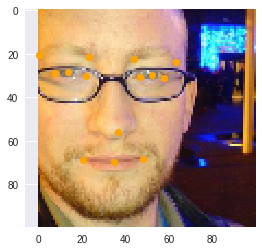

Predicted


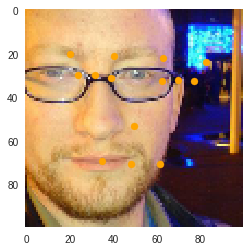

True


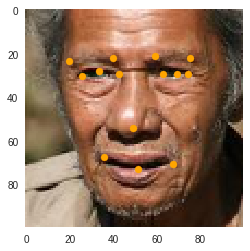

Predicted


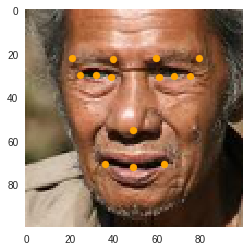

True


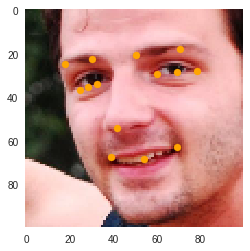

Predicted


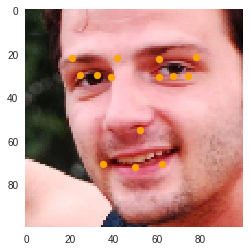

True


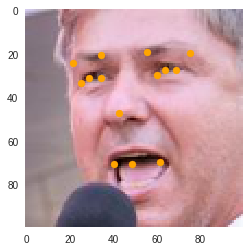

Predicted


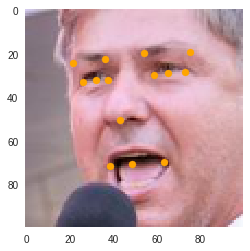

True


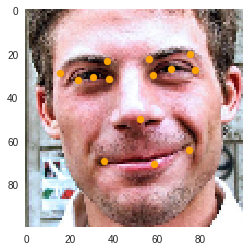

Predicted


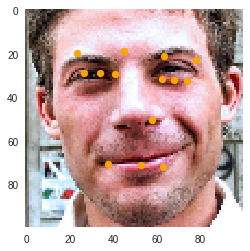

True


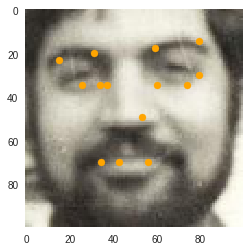

Predicted


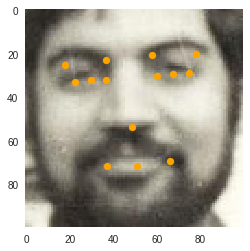

True


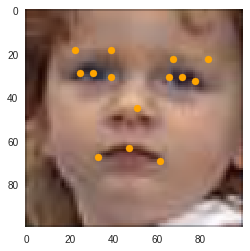

Predicted


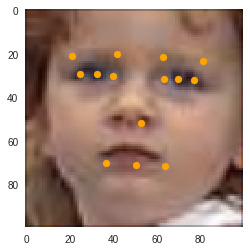

In [154]:
for i in range(10):   
    print("True")
    visualize_points(imgs_val[i], points_val[i])
    print("Predicted")
    visualize_points(imgs_val[i], predict[i])

#### We see that in out of 10 images 9 have correct key points. Predictions are close to correct in about in 90% of cases 